In [956]:
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
%matplotlib inline
import gym
import math
import random
from collections import namedtuple
from itertools import count
from PIL import Image
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import torchvision.transforms as T  
import os
os.environ['KMP_DUPLICATE_LIB_OK']='True'
import pandas as pd
from sklearn import preprocessing
from sklearn.preprocessing import StandardScaler

In [961]:
class DeepQN(nn.Module):
    def __init__(self,window_size):
        super().__init__()
        self.fc1 = nn.Linear(in_features=window_size, out_features=128)   
        self.fc2 = nn.Linear(in_features=128, out_features=128)
        self.out = nn.Linear(in_features=128, out_features=3)
    def forward(self, temp):
        
        temp = F.relu(self.fc1(temp))
        temp = F.relu(self.fc2(temp))
        vals = self.out(temp)
        return vals

In [962]:
class ReplayMemory():
    def __init__(self, capacity):
        self.capacity = capacity
        self.memory = []
        self.count = 0
    def push_experience(self, experience):
        temp=len(self.memory)
        if temp < self.capacity:
            self.memory.append(experience)
        else:
            self.memory[self.count % self.capacity] = experience
        self.count += 1 
    def provide_sample(self, batch_size):
        return random.sample(self.memory, batch_size)    
    def can_provide_sample(self, batch_size):
        temp=len(self.memory)
        return temp >= batch_size

In [963]:
class EpsilonGreedyStrategy():
    def __init__(self, initial_val, final_val, decay_rate):
        self.initial_val = initial_val
        self.final_val = final_val
        self.decay_rate = decay_rate
    def get_exploration_rate(self, step):
        return self.final_val + (self.initial_val - self.final_val) * math.exp(-1. * step * self.decay_rate)
    

In [964]:
class Agent():
    def __init__(self, strategy,device):
        self.step = 0
        self.strategy = strategy
        self.device=device
    def select_action(self, state, policy,balance,timestep,stocks):
        rate = self.strategy.get_exploration_rate(self.step)
        self.step += 1
        if rate > random.random():
            action = random.randrange(0,3)
            return torch.tensor([action]).to(self.device)    
        else:
            with torch.no_grad():
                q_vals=policy.forward(state.float())
                action=torch.argmax(q_vals)
                return torch.tensor([action]).to(self.device) 
    def Test_action(self,state,policy,balance,timestep,stocks):
        with torch.no_grad():
                q_vals=policy.forward(state.float())
             
                action=torch.argmax(q_vals)
                return torch.tensor([action]).to(self.device)          

In [965]:
class Environment():
    def __init__(self, device,window_size):
        self.device = device
        self.df=pd.read_csv("TSLADaily.csv")
        self.test_df=pd.read_csv("TSLADailyTest-2.csv")   
        self.window_size=window_size
    def get_test_duration(self):
        return len(self.test_df)
    def get_train_duration(self):
        return len(self.df)
    def reset(self):
        balance=10000
        stocks=0
        current_stocks=0
        return balance,stocks,current_stocks
    def take_action(self, action,timestep,balance,max_stocks,current_stocks,stocks,stocks_per_buy):        
        curr_price=float(self.get_stockprice(timestep))
        final_price=float(self.get_stockprice(timestep+1))
        initial_val=stocks*curr_price+balance
        final_val=0
        if action==2:
            stocks_available=stocks_per_buy
            if stocks_available+stocks>max_stocks:
                stocks_available=max_stocks-stocks
            if curr_price*stocks_available<balance:
                stocks_bought=stocks_available
                balance-=curr_price*stocks_bought
                stocks += stocks_bought
            else:
                stocks_bought=int(balance/curr_price)
                balance=balance-curr_price*stocks_bought
                stocks+=stocks_bought
            current_stocks += stocks_bought       
        if action==0:
            balance += curr_price*stocks
            stocks=0
            current_stocks=0
        final_val=stocks*final_price+balance 
        reward=final_val-initial_val   
        return final_val,reward,balance,stocks,current_stocks        
   
    def get_state(self,balance,timestep):
        data=self.df
        data=data.to_numpy()
        data=data[timestep:self.window_size+timestep]
        scaler = StandardScaler()
        scaler.fit(data)
        data=scaler.transform(data)
        data=data[:,1]
        data=torch.from_numpy(data)
        return data
    def get_test_state(self,balance,timestep):
        data=self.test_df
        data=data.to_numpy()
        data=data[timestep:self.window_size+timestep]
        scaler = StandardScaler()
        scaler.fit(data)
        data=scaler.transform(data)
        data=data[:,1]
        data=torch.from_numpy(data)
        return data
    def get_stockprice(self,timestep):
        data=self.df
        data=data.to_numpy()
        data=data[:,1]
        data=torch.from_numpy(data)
        return data[timestep+self.window_size]
    def take_test_action(self, action,timestep,balance,max_stocks,current_stocks,stocks,stocks_per_buy):        
        curr_price=float(self.get_test_stockprice(timestep))
        final_price=float(self.get_test_stockprice(timestep+1))
        initial_val=stocks*curr_price+balance
        final_val=0
        if action==2:
            stocks_available=stocks_per_buy
            if stocks_available+stocks>max_stocks:
                stocks_available=max_stocks-stocks
            if curr_price*stocks_available<balance:
                stocks_bought=stocks_available
                balance-=curr_price*stocks_bought
                stocks += stocks_bought
            else:
                stocks_bought=int(balance/curr_price)
                balance=balance-curr_price*stocks_bought
                stocks+=stocks_bought
            current_stocks += stocks_bought    
        if action==0:     
            balance += curr_price*stocks
            stocks=0
            current_stocks=0
        final_val=stocks*final_price+balance 
        reward=final_val-initial_val
        return final_val,reward,balance,stocks,current_stocks 
    def get_test_stockprice(self,timestep):
        data=self.test_df
        data=data.to_numpy()
        data=data[:,1]
        data=torch.from_numpy(data)
        return data[timestep+self.window_size]

In [966]:
def plot(values, moving_avg_period):
    plt.figure(2)
    plt.clf()        
    plt.title('Training')
    plt.xlabel('Episode')
    plt.ylabel('Profits')
    plt.plot(values)
    plt.plot(get_moving_average(moving_avg_period, values))
    plt.pause(0.001)
    
    if is_ipython: display.clear_output(wait=True)

In [967]:
def get_moving_average(period, values):
    values = torch.tensor(values, dtype=torch.float)
    if len(values) >= period:
        moving_avg = values.unfold(dimension=0, size=period, step=1).mean(dim=1).flatten(start_dim=0)
        moving_avg = torch.cat((torch.zeros(period-1), moving_avg))
        return moving_avg.numpy()
    else:
        moving_avg = torch.zeros(len(values))
        return moving_avg.numpy()

In [968]:
class QValues():
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    def get_current(policy, states, actions,batch_size,vals):
        q_vals=policy.forward(states.float())
        vals.append(q_vals)
        q_val=torch.gather(q_vals,1,actions)
        return q_val
    def get_next(target_net, next_states):                
        values = target_net(next_states.float()).max(dim=1)[0]
        return values

In [969]:
batch_size = 128
gamma = 0.95
eps_initial = 1
eps_final = 0.01
eps_rate = 0.005
update = 10
memory_size = 100000
max_stocks=50
stocks_per_buy=10
lr = 0.01
num_episodes = 100
window_size=64
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
env = Environment(device,window_size)
strategy = EpsilonGreedyStrategy(eps_initial, eps_final, eps_rate)
train_length=env.get_train_duration()
test_length=env.get_test_duration()-window_size-1
policy = DeepQN(window_size).to(device)
target = DeepQN(window_size).to(device)
target.load_state_dict(policy.state_dict())
target.eval()
optimizer = optim.Adam(params=policy.parameters(), lr=lr)
agent = Agent(strategy, device)
memory = ReplayMemory(memory_size)
Experience = namedtuple('Experience',('state', 'action', 'next_state', 'reward','timestep'))

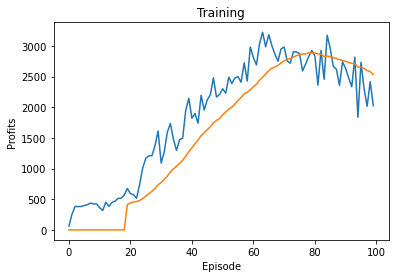

In [971]:
portfolio_vals=[]
loss_vals=[]
reward_list=[]
num_buy=[]
num_sell=[]
num_hold=[]
vals=[]
total_reward=np.zeros(num_episodes)
i=0
for episode in range(num_episodes):
    balance,stocks,current_stocks=env.reset()
    total_loss=0
    buy=0
    sell=0
    hold=0
    for timestep in range(i,i+test_length):
        times=torch.tensor([timestep]).to(device)
        state=env.get_state(balance,timestep)
        action = agent.select_action(state, policy,balance,timestep,stocks)
        final_val,reward,balance,stocks,current_stocks = env.take_action(action,timestep,balance,max_stocks,current_stocks,stocks,stocks_per_buy)
        reward=torch.tensor([reward]).to(device)
        if action==1:
            hold+=1
        elif action==0:
            sell+=1
        else:
            buy+=1
        next_state = env.get_state(balance,timestep+1)
        memory.push_experience(Experience(state, action.clone().detach(), next_state, reward,times))
        if memory.can_provide_sample(batch_size):
            experiences = memory.provide_sample(batch_size)
            batch = Experience(*zip(*experiences))
            states = torch.stack(batch.state)
            actions = torch.stack(batch.action)
            rewards = torch.stack(batch.reward)
            next_states = torch.stack(batch.next_state)
            timesteps=torch.stack(batch.timestep)
            current_q = QValues.get_current(policy, states, actions,batch_size,vals)
            next_q = QValues.get_next(target, next_states)
            next_q=torch.reshape(next_q,(batch_size,1))
            for j in range(batch_size):
                if experiences[4]==j+test_length-1:
                    target_q=rewards
                else:
                    target_q = (next_q * gamma) + rewards
            loss = F.mse_loss(current_q, target_q)
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            total_loss+=loss
            total_reward[episode]+=reward
    portfolio_vals.append(final_val)
    loss_vals.append(total_loss)
    reward_list.append(total_reward[episode])
    plot(reward_list,20)
    num_buy.append(buy)
    num_sell.append(sell)
    num_hold.append(hold)
    if episode % update == 0:
        target.load_state_dict(policy.state_dict()) 
    i=i+10    

In [972]:
balance,stocks,current_stocks=env.reset()
balance=10000
correct=0
bought=0
sold=0
actions=np.zeros(test_length)
rewards=0
for timestep in range(0,test_length):
        state=env.get_test_state(balance,timestep)
        action = agent.Test_action(state,policy,balance,timestep,stocks)
        final_val,reward,balance,stocks,current_stocks = env.take_test_action(action,timestep,balance,max_stocks,current_stocks,stocks,stocks_per_buy)
        rewards+=reward
        reward=torch.tensor([reward]).to(device)
        next_state = env.get_test_state(balance,timestep+1)
        state = next_state
        curr_price=env.get_test_stockprice(timestep)
        next_price=env.get_test_stockprice(timestep+1)
        if curr_price>next_price:
            if action==0:
                correct+=1
        else:
            if action==2:
                correct+=1
        print("Day:"+str(timestep+1))        
        if action==2:
            print("Action: Buy")
            bought+=1
        elif action==0:
            print("Action:Sell")
            sold+=1
        else:
            print("Action:Hold")
        actions[timestep]=int(action)
        print("Money:"+str(balance))
        print("Stocks Held:"+str(stocks))
        print("Profit:"+str(float(reward)))
        print("Portfolio Value:"+str(final_val))
        print("-----------------------------------")
print("Final Portfolio Value="+str(final_val))    

Day:1
Action: Buy
Money:9333.74001
Stocks Held:10
Profit:1.6799999475479126
Portfolio Value:10001.68
-----------------------------------
Day:2
Action:Sell
Money:10001.68
Stocks Held:0
Profit:0.0
Portfolio Value:10001.68
-----------------------------------
Day:3
Action:Sell
Money:10001.68
Stocks Held:0
Profit:0.0
Portfolio Value:10001.68
-----------------------------------
Day:4
Action: Buy
Money:9371.21999
Stocks Held:10
Profit:-9.620010375976562
Portfolio Value:9992.05999
-----------------------------------
Day:5
Action:Sell
Money:9992.05999
Stocks Held:0
Profit:0.0
Portfolio Value:9992.05999
-----------------------------------
Day:6
Action: Buy
Money:9360.599989999999
Stocks Held:10
Profit:15.86001968383789
Portfolio Value:10007.920009999998
-----------------------------------
Day:7
Action: Buy
Money:8713.27997
Stocks Held:20
Profit:-5.40008020401001
Portfolio Value:10002.519929999999
-----------------------------------
Day:8
Action: Buy
Money:8068.65999
Stocks Held:30
Profit:70.5601

Day:150
Action: Buy
Money:7740.759960000005
Stocks Held:50
Profit:222.59994506835938
Portfolio Value:10595.759860000006
-----------------------------------
Day:151
Action: Buy
Money:7740.759960000005
Stocks Held:50
Profit:-60.59989929199219
Portfolio Value:10535.159960000005
-----------------------------------
Day:152
Action: Buy
Money:7740.759960000005
Stocks Held:50
Profit:111.0000991821289
Portfolio Value:10646.160060000006
-----------------------------------
Day:153
Action: Buy
Money:7740.759960000005
Stocks Held:50
Profit:-10.800200462341309
Portfolio Value:10635.359860000004
-----------------------------------
Day:154
Action:Sell
Money:10635.359860000004
Stocks Held:0
Profit:0.0
Portfolio Value:10635.359860000004
-----------------------------------
Day:155
Action:Sell
Money:10635.359860000004
Stocks Held:0
Profit:0.0
Portfolio Value:10635.359860000004
-----------------------------------
Day:156
Action:Sell
Money:10635.359860000004
Stocks Held:0
Profit:0.0
Portfolio Value:10635.35

-----------------------------------
Day:280
Action:Sell
Money:10969.920010000005
Stocks Held:0
Profit:0.0
Portfolio Value:10969.920010000005
-----------------------------------
Day:281
Action: Buy
Money:10434.980020000005
Stocks Held:10
Profit:12.26002025604248
Portfolio Value:10982.180030000005
-----------------------------------
Day:282
Action:Sell
Money:10982.180030000005
Stocks Held:0
Profit:0.0
Portfolio Value:10982.180030000005
-----------------------------------
Day:283
Action:Sell
Money:10982.180030000005
Stocks Held:0
Profit:0.0
Portfolio Value:10982.180030000005
-----------------------------------
Day:284
Action:Sell
Money:10982.180030000005
Stocks Held:0
Profit:0.0
Portfolio Value:10982.180030000005
-----------------------------------
Day:285
Action:Sell
Money:10982.180030000005
Stocks Held:0
Profit:0.0
Portfolio Value:10982.180030000005
-----------------------------------
Day:286
Action:Sell
Money:10982.180030000005
Stocks Held:0
Profit:0.0
Portfolio Value:10982.18003000000

Portfolio Value:11134.979690000002
-----------------------------------
Day:423
Action: Buy
Money:8689.679790000002
Stocks Held:50
Profit:2.1001999378204346
Portfolio Value:11137.079890000003
-----------------------------------
Day:424
Action: Buy
Money:8689.679790000002
Stocks Held:50
Profit:31.499849319458008
Portfolio Value:11168.579740000001
-----------------------------------
Day:425
Action: Buy
Money:8689.679790000002
Stocks Held:50
Profit:90.699951171875
Portfolio Value:11259.279690000003
-----------------------------------
Day:426
Action: Buy
Money:8689.679790000002
Stocks Held:50
Profit:9.300049781799316
Portfolio Value:11268.579740000001
-----------------------------------
Day:427
Action: Buy
Money:8689.679790000002
Stocks Held:50
Profit:18.600099563598633
Portfolio Value:11287.179840000003
-----------------------------------
Day:428
Action: Buy
Money:8689.679790000002
Stocks Held:50
Profit:22.200000762939453
Portfolio Value:11309.379840000001
---------------------------------

/Users/tanush/opt/anaconda3/lib/python3.8/site-packages/matplotlib/lines.py:191: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return Path(verts[markevery], _slice_or_none(codes, markevery))


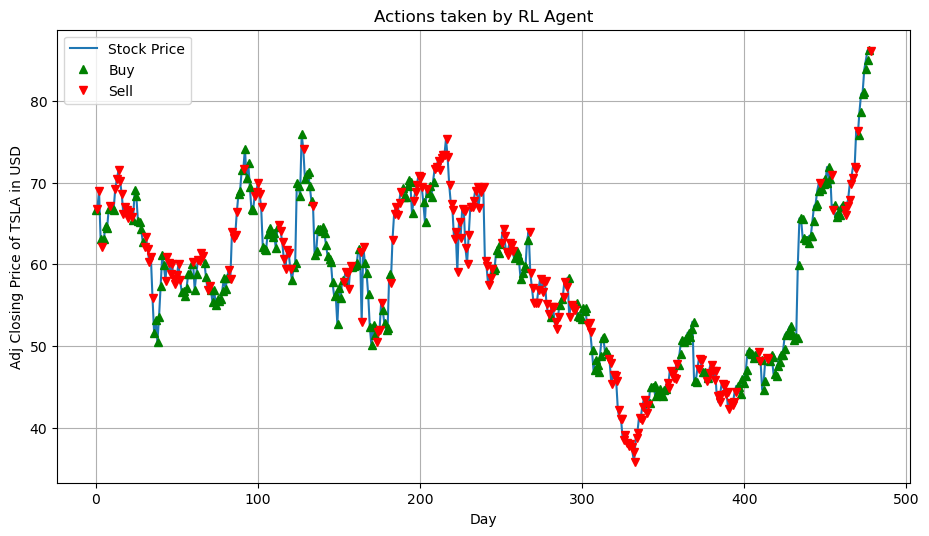

In [973]:
df=pd.read_csv("TSLADailyTest-2.csv")
df=df.to_numpy()
df=df[:,1]
plt.figure(figsize=(11,6),dpi=100)
plt.plot(df[window_size:test_length+window_size])
a=(actions==2)
markers_on = [a]
labels=["Stock Price","Buy","Sell"]
b=(actions==0)

plt.plot(np.linspace(0,test_length,num=test_length),df[window_size:window_size+test_length], '-b^', markevery=markers_on,mfc='g',mec='g',linestyle="")  
markers_on=[b]
plt.plot(np.linspace(0,test_length,num=test_length),df[window_size:window_size+test_length], '-bv', markevery=markers_on,mfc='r',mec='r',linestyle="")     
plt.grid()
plt.legend(labels)
plt.title("Actions taken by RL Agent")
plt.xlabel('Day')
plt.ylabel('Adj Closing Price of TSLA in USD')

plt.show()

In [974]:
print("Total Profits: $"+str(final_val-10000))

Total Profits: $2532.4000099999976
